In [2]:
CUDA_VISIBLE_DEVICES=1
class Args:
    def __init__(self):
        self.model_name = 'crosstask'
        self.weights_path = "./models/GenHowTo/weights/GenHowTo-STATES-96h-v1"
        self.device = "cuda"
        self.num_inference_steps = 50
        self.num_steps_to_skip = None
        self.guidance_scale = 9.0
        self.max_traj_len = 3
        self.dataset = 'crosstask'
        self.num_action = 133
        self.num_tasks = 18
        self.epochs = 500
        self.batch_size = 1
        self.dropout = 0.2
        self.optimizer = 'adam'
        self.lr = 0.004
        self.step_size = 40
        self.lr_decay = 0.65
        self.weight_decay = 0.0001
        self.M = 2
        self.aug_range = 0
        self.no_state_task = False
        self.root_dir = 'dataset/crosstask/crosstask_release'
        self.train_json = 'dataset/crosstask/cross_task_data_False.json'
        self.valid_json = 'dataset/crosstask/cross_task_data_True.json'
        self.features_dir = '/home/yulei/data/crosstask/processed_data/'
        self.vid_dir = '/home/yulei/data/crosstask/crosstask_videos/videos/'
        self.img_dir = '/dvmm-filer3a/users/ali/Data/CrossTask/crosstask_frame_states'
        self.return_frames = True
        self.save_image_states = False
        self.eval_mode = False
        self.saved_path = 'checkpoints'
        self.last_epoch = -1
        self.split = 'base'
        self.seed = 3407
        self.uncertain = False
        self.num_sample = 1500

# Create an instance of Args
args = Args()

# Use the variables in your code
# For example:
print(args.model_name)
print(args.weights_path)


crosstask
./models/GenHowTo/weights/GenHowTo-STATES-96h-v1


In [3]:
import torch
import os
import time
import numpy as np
import math
from utils import *
from metrics import *
from torch.utils.data import DataLoader
from models.procedure_model import ProcedureModel
from models.utils import AverageMeter
import wandb
from tools.parser import create_parser
from PIL import Image

from models.GenHowTo.genhowto_utils import load_genhowto_model, DDIMSkipScheduler




        
if args.dataset == 'crosstask':
    if args.split == 'base':
        from dataset.my_crosstask_dataloader import CrossTaskDataset as ProcedureDataset
    elif args.split == 'pdpp':
        # use PDPP data split and data sample
        from dataset.crosstask_dataloader_pdpp import CrossTaskDataset as ProcedureDataset
    elif args.split == 'p3iv':
        # use P3IV data split and data sample
        assert args.max_traj_len == 3, "Only the datasplit for max_traj_len = 3 is available."
        from dataset.crosstask_dataloader_p3iv import CrossTaskDataset as ProcedureDataset

elif args.dataset == 'coin':
    from dataset.coin_dataloader import CoinDataset as ProcedureDataset

elif args.dataset == 'niv':
    from dataset.niv_dataloader import NivDataset as ProcedureDataset


/dvmm-filer2/users/ali/anaconda3/envs/envPP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

logger_path = "logs/{}_{}_len{}".format(
                time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()), 
                args.model_name, 
                args.max_traj_len)
if args.last_epoch > -1:
    logger_path += "_last{}".format(args.last_epoch)
os.makedirs(logger_path)
log_file_path = os.path.join(logger_path, "log.txt")
logger = get_logger(log_file_path)
logger.info("{}".format(log_file_path))
logger.info("{}".format(args))

validate_interval = 1
setup_seed(args.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if args.dataset == 'crosstask':
    logger.info("Loading prompt features...")
    file_path = './data/descriptors_crosstask.json'
    # Load the JSON file
    with open(file_path, 'r') as f:
        state_prompts = json.load(f)
    #state_prompt_features = np.load(f'./data/state_description_features/crosstask_state_prompt_features.npy')

    ## parse raw data
    task_info_path = os.path.join(args.root_dir, "tasks_primary.txt")
    task_info = parse_task_info(task_info_path)
    with open("data/crosstask_idices.json", "r") as f:
        idices_mapping = json.load(f)
    anot_dir = os.path.join(args.root_dir, "annotations")
    anot_info = parse_annotation(anot_dir, task_info, idices_mapping)

    logger.info("Loading training data...")
    train_dataset = ProcedureDataset(anot_info, args.img_dir, state_prompts, 
                                    args.train_json, args.max_traj_len, aug_range=args.aug_range, 
                                    mode = "train", M=args.M,
                                    vid_dir=args.vid_dir,
                                    save_image_states=args.save_image_states)
    
    logger.info("Loading valid data...")
    valid_dataset = ProcedureDataset(anot_info, args.img_dir, state_prompts, 
                                    args.valid_json, args.max_traj_len, aug_range=args.aug_range, 
                                    mode = "valid", M=args.M,
                                    vid_dir=args.vid_dir,
                                    save_image_states=args.save_image_states)
    transition_matrix = train_dataset.transition_matrix
    
elif args.dataset == "coin":
    raise NotImplementedError
    logger.info("Loading prompt features...")
    state_prompt_features = np.load(f'./data/state_description_features/coin_state_prompt_features.npy')

    logger.info("Loading training data...")
    train_dataset = ProcedureDataset(args.features_dir, state_prompt_features, 
                                    args.train_json, args.max_traj_len, aug_range=args.aug_range, 
                                    mode = "train", M=args.M)
    
    logger.info("Loading valid data...")
    valid_dataset = ProcedureDataset(args.features_dir, state_prompt_features, 
                                    args.valid_json, args.max_traj_len, aug_range=args.aug_range, 
                                    mode = "valid", M=args.M)
    transition_matrix = train_dataset.transition_matrix

elif args.dataset == "niv":
    raise NotImplementedError
    logger.info("Loading prompt features...")
    state_prompt_features = np.load(f'./data/state_description_features/niv_state_prompt_features.npy')

    logger.info("Loading training data...")
    train_dataset = ProcedureDataset(args.features_dir, state_prompt_features, 
                                    args.train_json, args.max_traj_len, num_action = 48,
                                    aug_range=args.aug_range, mode = "train", M=args.M)
    
    logger.info("Loading valid data...")
    valid_dataset = ProcedureDataset(args.features_dir, state_prompt_features,
                                    args.valid_json, args.max_traj_len, num_action = 48,
                                    aug_range=args.aug_range, mode = "valid", M=args.M)
    transition_matrix = train_dataset.transition_matrix

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4)

logger.info("Training set volumn: {} Testing set volumn: {}".format(len(train_dataset), len(valid_dataset)))
# Initialize wandb
#wandb_config=vars(args)
#wandb.init(project='vPP', config=wandb_config)

pipe = load_genhowto_model(args.weights_path, device=device)
logger.info("the model is loaded.")

[2024-04-19 10:00:56,950][1396166359.py][line:10][INFO] logs/2024-04-19-10-00-56_crosstask_len3/log.txt
[2024-04-19 10:00:56,951][1396166359.py][line:11][INFO] <__main__.Args object at 0x7f9065701600>
[2024-04-19 10:00:56,952][1396166359.py][line:18][INFO] Loading prompt features...
[2024-04-19 10:01:08,889][1396166359.py][line:33][INFO] Loading training data...
Processing videos: 100%|██████████| 2200/2200 [00:46<00:00, 47.46it/s] 
[2024-04-19 10:01:55,255][1396166359.py][line:40][INFO] Loading valid data...
Processing videos: 100%|██████████| 340/340 [00:07<00:00, 44.75it/s]
[2024-04-19 10:02:02,860][1396166359.py][line:83][INFO] Training set volumn: 11884 Testing set volumn: 1958
[2024-04-19 10:02:15,760][1396166359.py][line:89][INFO] the model is loaded.


In [75]:
for data in train_loader:
    #  data[0] : batch*n_act*2(start, end frames)*w*h*3(RGB)
    # data[1]: list [ac_1,ac_2,ac_3] ac_i[key:description, before, after]=batch*[str] 
    # data[3]: data[3].shape torch.Size([256]) of task ids
    pipe.scheduler.set_timesteps(args.num_inference_steps)
    
    #set the scheduler of GenHowTo (on per instance bases)
    if args.num_steps_to_skip is not None:  # possibly do not start from complete noise
        pipe.scheduler = DDIMSkipScheduler.from_config(pipe.scheduler.config)
        pipe.scheduler.set_num_steps_to_skip(args.num_steps_to_skip, args.num_inference_steps)
        print(f"Skipping first {args.num_steps_to_skip} DDIM steps, i.e., running DDIM from timestep "
            f"{pipe.scheduler.timesteps[0]} to {pipe.scheduler.timesteps[-1]}.")
        
    input=data[0][:,0,0,...].clone() 
    img_input = [Image.fromarray(( idd.numpy()).astype(np.uint8)) for idd in input]
    all_outs=[img_input]
    all_prompts=[]
    for action_id in range(args.max_traj_len):
        for state_mode in ['after']:
            prompt=[data[1][action_id][state_mode][idd][0] for idd in range(args.batch_size)]
            latents = torch.randn((args.batch_size, 4, 64, 64))
            if args.num_inference_steps is not None:
                z = pipe.control_image_processor.preprocess(img_input)
                z = z * pipe.vae.config.scaling_factor
                t = pipe.scheduler.timesteps[0]
                alpha_bar = pipe.scheduler.alphas_cumprod[t].item()
                latents = math.sqrt(alpha_bar) * z + math.sqrt(1. - alpha_bar) * latents.to(z.device)
            
            
            #prompt_embeds=pipe.text_encoder(torch.tensor(pipe.tokenizer(prompt)['input_ids']).to(device)).last_hidden_state
                
            output = pipe(
            image=img_input,prompt=prompt,
            guidance_scale=args.guidance_scale,
            num_inference_steps=args.num_inference_steps,
            latents=latents,
            num_images_per_prompt=1,
            return_dict=True,
            ).images
            all_outs.append(output)
            all_prompts.append(prompt)
            img_input=[idd for idd in output]
    break

100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


The pancake mixture is smooth.


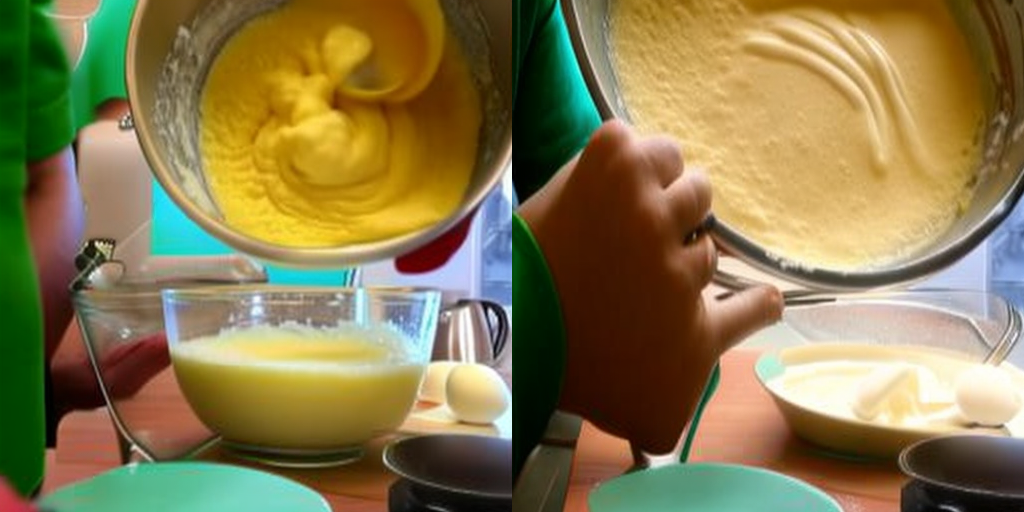

In [79]:
batch_id=0
inst_id=2
inst_prompt=all_prompts[inst_id][batch_id]
im_prev=all_outs[inst_id][batch_id]
im_next=all_outs[inst_id+1][batch_id]
print(inst_prompt)
# Calculate the width and height of the new image
new_width = im_prev.width + im_next.width
new_height = max(im_prev.height, im_next.height)

# Create a new image with white background
new_image = Image.new("RGB", (new_width, new_height), (255, 255, 255))

# Paste the first image at the leftmost position
new_image.paste(im_prev, (0, 0))

# Paste the second image at the position next to the first image
new_image.paste(im_next, (im_prev.width, 0))

# Display or save the new image
new_image.show()

In [29]:
data[1]

[{'description': ['Add flour into the cake batter'],
  'before': [('The flour is in a bowl.',),
   ('The cake batter contains no flour.',),
   ('The flour is a powder.',)],
  'after': [('The flour is mixed with the cake batter.',),
   ('The flour is in the mixing bowl.',),
   ('The cake batter contains flour.',)]},
 {'description': ['Whisk the mixture together'],
  'before': [('The mixture is in a bowl.',),
   ('The bowl contains separate ingredients.',),
   ('The ingredients are not mixed.',)],
  'after': [('The mixture is blended together.',),
   ('The bowl contains a blended mixture.',),
   ('The ingredients are combined.',)]},
 {'description': ['Spread creme upon the cake'],
  'before': [('The creme is in a bowl.',),
   ('The cake has no creme on it.',),
   ('The creme is a whole.',)],
  'after': [('The creme is spread on the cake.',),
   ('The creme is on the cake.',),
   ('The cake contains creme.',)]}]

In [45]:
Ali=pipe.text_encoder(torch.tensor(pipe.tokenizer(prompt)['input_ids']).to(device))

In [49]:
Ali.last_hidden_state.shape

torch.Size([1, 10, 1024])